In [1]:
import gvar as gv
import h5py
import numpy as np
import lsqfit

import matplotlib.pyplot as plt 
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.size']  = 20
plt.rcParams['legend.fontsize'] =  16
plt.rcParams["lines.markersize"] = 5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.usetex'] = False
plt.rcParams["figure.figsize"] = (10,7)

## Define physical point data

In [2]:
data_phys_point = {
    'eps2_a' : gv.gvar(0),
    'a' : gv.gvar(0),
    'alpha_s' : gv.gvar(0.0),
    'L' : gv.gvar(np.infty),
    'hbarc' : gv.gvar(197.3269804, 0), # MeV-fm

    'lam_chi' : 4 *np.pi *gv.gvar('92.07(57)'),
    'f_pi' : gv.gvar('92.07(57)'),
    'f_k' : gv.gvar('109.96(49)'),
    'm_pi' : gv.gvar('134.8(3)'), # '138.05638(37)'
    'm_k' : gv.gvar('494.2(3)'), # '495.6479(92)'
}

for obs in ['pi', 'k']:
    data_phys_point['eps_'+obs] = data_phys_point['m_'+obs] / data_phys_point['lam_chi']


## Load data from h5 file

In [3]:
def get_bs_data(file_h5, ensembles=None):
    if ensembles is None:
        with h5py.File(file_h5, "r") as f:
            ensembles = list(f.keys())

    data = {}
    with h5py.File(file_h5, 'r') as f: 
        for ens in ensembles:
            data[ens] = {}
            data[ens]['alpha_s'] = f[ens]['alpha_s'][()]
            data[ens]['L'] = f[ens]['L'][()]
            data[ens]['eps_pi'] = f[ens]['mpi'][1:] / (4 *np.pi *f[ens]['Fpi'][1:])
            data[ens]['eps_k'] = f[ens]['mk'][1:] / (4 *np.pi *f[ens]['Fpi'][1:])
            data[ens]['lam_chi'] = 4 *np.pi *f[ens]['Fpi'][1:]
            data[ens]['f_pi'] = f[ens]['Fpi'][1:]
            data[ens]['f_k'] = f[ens]['FK'][1:]
            data[ens]['aw0'] = f[ens]['aw0'][:]

    return data


def load_data(file_h5, ensembles=None):
    to_gvar = lambda arr : gv.gvar(arr[0], arr[1]) 

    bs_data = get_bs_data(file_h5=file_h5, ensembles=ensembles)
    ensembles = list(bs_data)
    
    gv_data = {}
    observables = ['eps_pi', 'eps_k', 'f_pi', 'lam_chi', 'f_k']
    for ens in ensembles:
        gv_data[ens] = {}
        for obs in observables:
            gv_data[ens][obs] = bs_data[ens][obs] #- np.mean(bs_data[ens][obs]) + bs_data[ens][obs][0]

        gv_data[ens] = gv.dataset.avg_data(gv_data[ens], bstrap=True) 

        gv_data[ens]['eps2_a'] = (to_gvar(bs_data[ens]['aw0'])/2)**2
        
    output = {}
    for param in gv_data[ensembles[0]]:
        output[param] = np.array([gv_data[ens][param] for ens in ensembles])

    return output, ensembles


file_h5 = './../data/xpt_data.h5'
data, ensembles = load_data(file_h5)

## Plot data

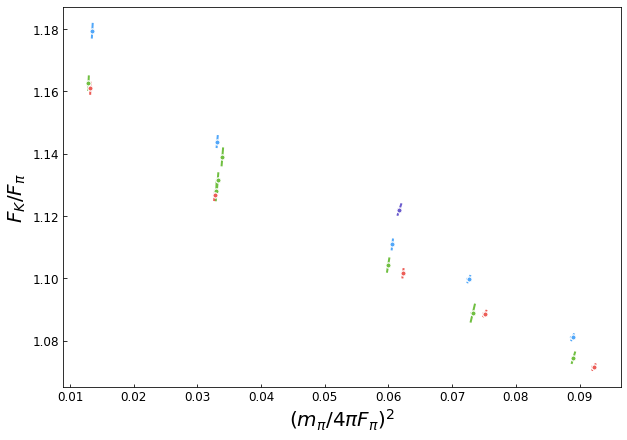

In [4]:
def plot_params(x, y, ensembles=None, xlabel=None, ylabel=None):
    colormap = {
            'a06' : '#6A5ACD',#'#00FFFF',
            'a09' : '#51a7f9',
            'a12' : '#70bf41',
            'a15' : '#ec5d57',
        }

    fig, ax = plt.subplots()

    for j, (xi, yi) in enumerate(zip(x, y)):
        if ensembles is not None:
            color = colormap[ensembles[j][:3]]
        else:
            color = 'k'

        cov = gv.evalcov([xi, yi])
        eigenvalue, eigenvector  = np.linalg.eig(cov)
        for w, v in zip(eigenvalue, eigenvector.T):
            ax.plot(
                [gv.mean(xi) - np.sqrt(w) *v[0], gv.mean(xi) + np.sqrt(w) *v[0]], 
                [gv.mean(yi) - np.sqrt(w) *v[1], gv.mean(yi) + np.sqrt(w) *v[1]], 
                alpha=1.0, lw=2, color=color)
            ax.plot(gv.mean(xi), gv.mean(yi), 
                color=color, marker='o', mec='w', zorder=3)

    if xlabel is not None:
        ax.set_xlabel(xlabel)

    if ylabel is not None:
        ax.set_ylabel(ylabel)

    plt.close()
    return fig

plot_params(
    x=data['eps_pi']**2, 
    y=data['f_k']/data['f_pi'], 
    ensembles=ensembles,
    xlabel='$(m_\pi/4 \pi F_\pi)^2$',
    ylabel='$F_K/F_\pi$')



## Define fit function (nlo xpt + n2lo Taylor)

In [5]:
def fitfcn(p):
    eps_pi = p['eps_pi']
    eps_k = p['eps_k']
    eps_eta = np.sqrt((4.0/3.0) *(eps_k**2) - (1.0/3.0) *(eps_pi**2))
    eps2_a = p['eps2_a']

    # lo
    output = 1

    # nlo
    output += (
        + 5/8 *eps_pi**2 *np.log(eps_pi**2)
        - 1/4 *eps_k**2 *np.log(eps_k**2)
        - 3/8 *eps_eta**2 *np.log(eps_eta**2)
        + 4 *p['L_5'] *(eps_k**2 - eps_pi**2)
    )

    # n2lo disc
    output += p['d_a'] *(eps_k**2 - eps_pi**2) *eps2_a

    # n2lo 
    output += (
        + p['c_p'] *(eps_k**2 - eps_pi**2) *eps_pi**2
        + p['c_k'] *(eps_k**2 - eps_pi**2) *eps_k**2
    )

    return output

## Fit

In [6]:
prior = {}
prior.update(data)
del(prior['f_k'])
del(prior['f_pi'])
del(prior['lam_chi'])
prior['L_5'] = gv.gvar(0, 1)
prior['d_a'] = gv.gvar(0, 5)
prior['c_p'] = gv.gvar(0, 5)
prior['c_k'] = gv.gvar(0, 10)

y = gv.gvar(gv.mean(data['f_k'] / data['f_pi']), gv.sdev(data['f_k'] / data['f_pi']))
#y = gv.gvar(data['f_k'] / data['f_pi'])

fit = lsqfit.nonlinear_fit(data=y, fcn=fitfcn, prior=prior)
print(fit)

Least Square Fit:
  chi2/dof [dof] = 1.4 [18]    Q = 0.12    logGBF = 66.953

Parameters:
       eps_pi 0    0.24894 (65)      [  0.24845 (71) ]  
              1    0.11620 (31)      [  0.11619 (33) ]  
              2    0.18172 (35)      [  0.18197 (37) ]  
              3    0.24617 (43)      [  0.24619 (44) ]  
              4    0.26968 (55)      [  0.26949 (58) ]  
              5    0.29818 (52)      [  0.29819 (54) ]  
              6    0.11355 (32)      [  0.11360 (33) ]  
              7    0.18213 (42)      [  0.18220 (44) ]  
              8    0.18140 (41)      [  0.18155 (42) ]  
              9    0.18447 (56)      [  0.18418 (58) ]  
             10    0.24493 (50)      [  0.24486 (51) ]  
             11    0.27053 (68)      [  0.27063 (69) ]  
             12    0.29829 (51)      [  0.29840 (52) ]  
             13    0.11487 (19)      [  0.11492 (20) ]  
             14    0.18091 (30)      [  0.18084 (31) ]  
             15    0.24969 (36)      [  0.24957 (36) ] 

## Extrapolate to physical point

In [7]:
posterior = {}
posterior.update(fit.p)
posterior.update(data_phys_point)

print(fitfcn(posterior))

1.1913(37)


## Plot fit

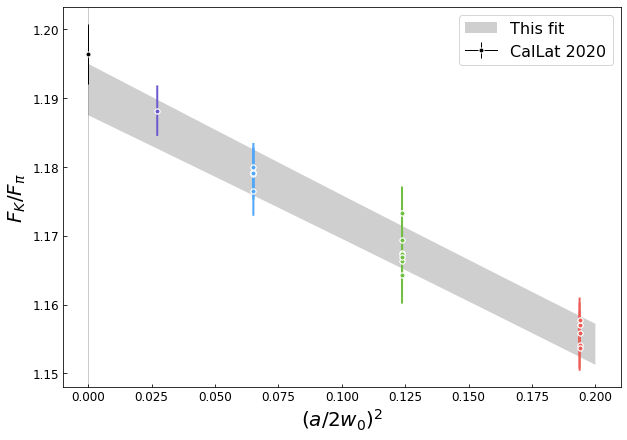

In [8]:
def plot_fit(fitfcn, data, data_phys_point, posterior, ensembles):

    # shift data to physical pion, kaon masses
    p = {}
    p.update(posterior)
    p.update(
        {
            'eps_pi' : data_phys_point['eps_pi'],
            'eps_k' : data_phys_point['eps_k']
        }
    )

    y_fit = fitfcn(posterior)
    y_lattice = data['f_k']/data['f_pi']
    y_fit_phys = fitfcn(p)

    y_shift = y_lattice + y_fit_phys - y_fit
    
    # plot data
    fig = plot_params(
        x=data['eps2_a'], 
        y=y_shift,
        ensembles=ensembles,
        xlabel='$(a/2 w_0)^2$',
        ylabel='$F_K/F_\pi$'
    )


    # plot fit band
    ax = fig.axes[0]

    p = {}
    p.update(posterior)
    p.update(data_phys_point)
    p.update({'eps2_a' : np.linspace(0, 0.2)})

    y = fitfcn(p)
    pm = lambda g, k : gv.mean(g) + k *gv.sdev(g)
    ax.fill_between(p['eps2_a'], pm(y, -1), pm(y, +1), facecolor='#A0A0A0', alpha=0.5, label='This fit')

    # show CalLat result
    ax.axvspan(0, 0, color='k', alpha=0.2)
    ax.errorbar(
        x=0, 
        xerr=0,
        y=1.1964,
        yerr=0.0044,
        marker='o', color='k', capsize=0.0, mec='white', label='CalLat 2020')

    ax.legend()
    plt.close()
    return fig


plot_fit(
    fitfcn=fitfcn, 
    data=data, 
    data_phys_point=data_phys_point, 
    posterior=fit.p, 
    ensembles=ensembles)